In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = ('associations/')
associations = os.listdir(path)

In [3]:

try:
    os.mkdir('associations/sig')
except Exception as e:
    print(e)
    pass

for association in associations:
    if association.endswith('.tsv'):
            try:
                df = pd.read_csv(path + association, sep = '\t')
                
            except pd.errors.EmptyDataError:
                #print('Note: ' + association + ' was empty. Skipping.')
                continue # will skip the rest of the block and move to next file

            if df.empty:
                continue
            else:
                d = df.loc[(df['lrt-pvalue'] <= 6.95E-06)] #computed using the pyseer count_patterns.py script

             # don't write out empty dataframes
            if d.empty:
                pass
            else:
                d.to_csv('associations/sig/' + association, sep = '\t', index = False)

In [5]:
path = ('associations/sig/')
files = os.listdir(path)

try:
    os.mkdir('associations/asso_variant')
except Exception as e:
    print(e)
    pass

# dictionary to rename the variants
# so that they can be used as filenames
d = {}
variant_id = 0

for file in files:
    if file.endswith('.tsv'):
        var = pd.read_csv(path + file, sep = '\t')
        for _, row in var.iterrows():
            
            name = row['variant']
            if name not in d:
                d[name] = variant_id
                variant_id += 1
            new_name = d[name]
            
            
            lrt = row['lrt-pvalue']

            beta = row['beta']
            
            samples = row['k-samples']

            o_var = open(f'associations/asso_variant/{file[:-4]}-{new_name}.tsv', 'w')
            o_var.write(f'{name}\t{lrt}\t{beta}\t{samples}\n')
            
            o_var.close()

# save the variant dictionary to file for future use
f = open('hashes_to_id.txt', 'w')
for k, v in d.items():
    f.write(f'{k}\t{v}\n')
f.close()

[Errno 17] File exists: 'associations/swarmplots'


/fast-storage/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast-storage/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast-storage/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/fast-storage/miniconda3/envs/jupyterlab/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 25.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/

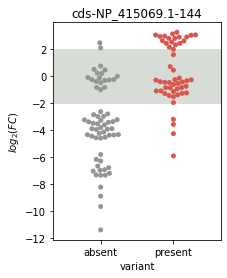

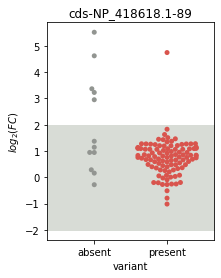

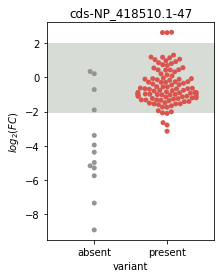

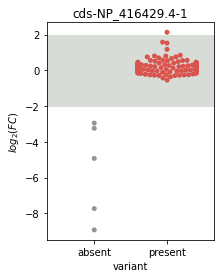

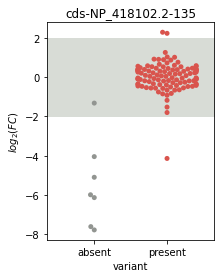

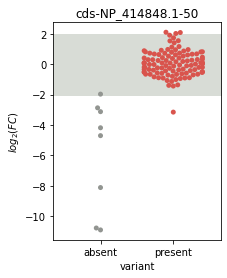

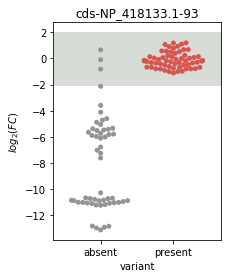

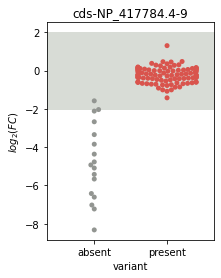

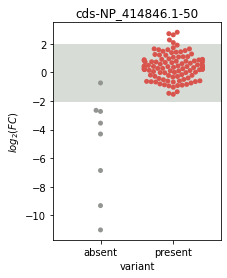

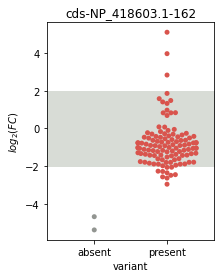

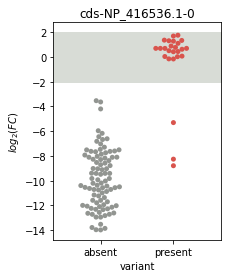

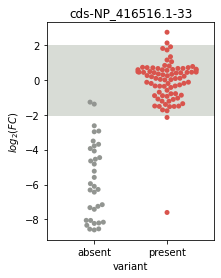

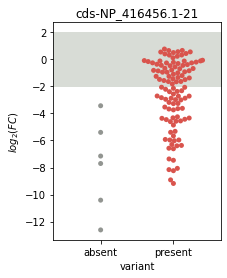

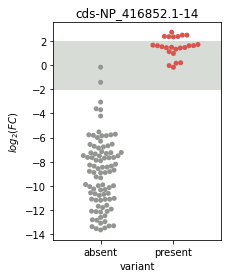

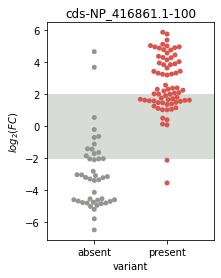

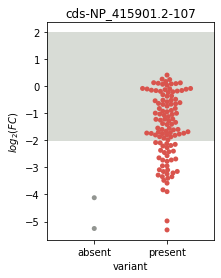

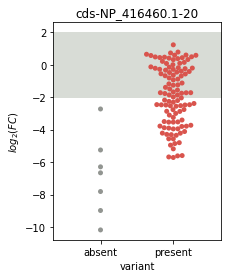

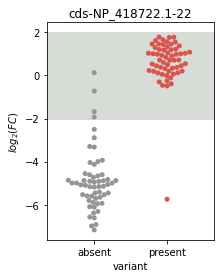

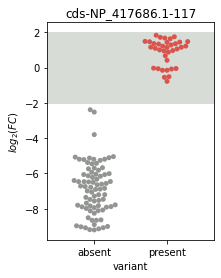

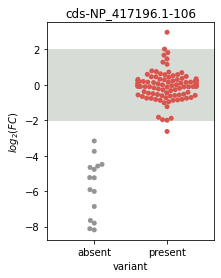

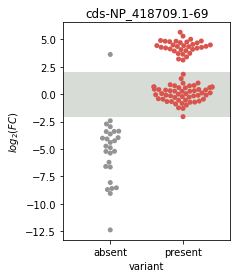

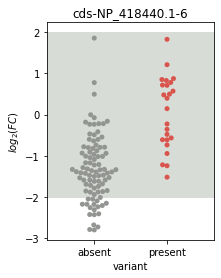

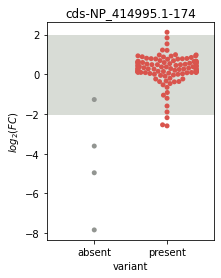

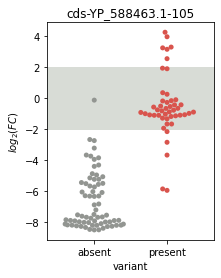

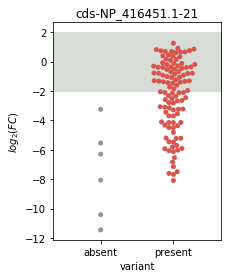

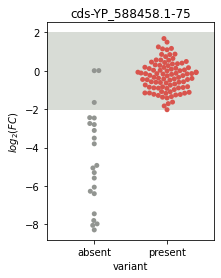

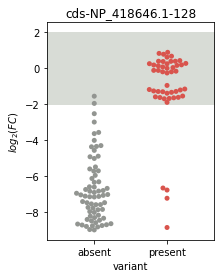

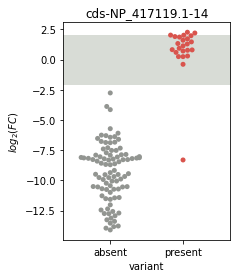

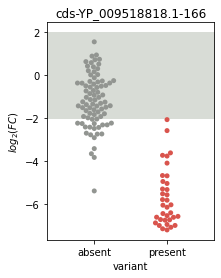

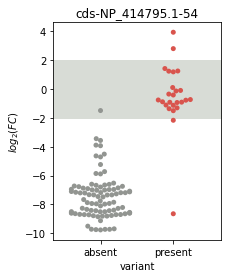

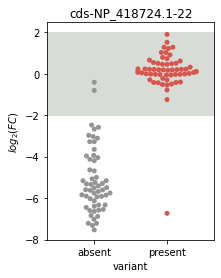

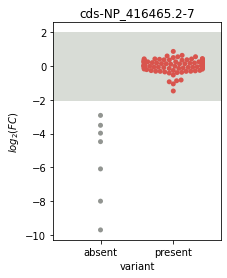

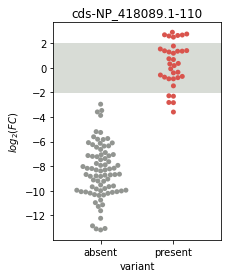

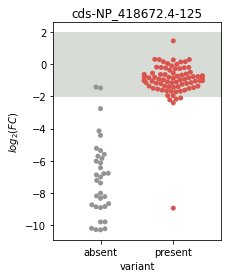

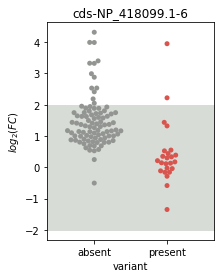

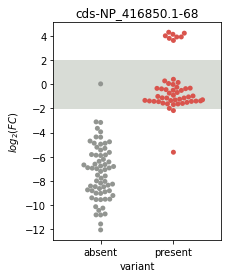

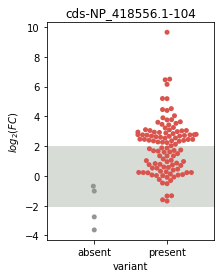

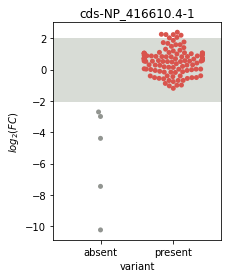

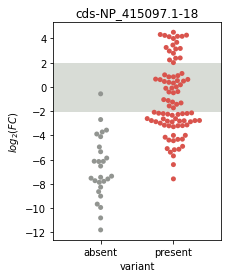

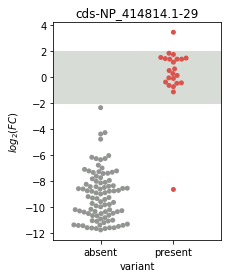

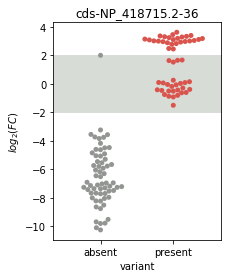

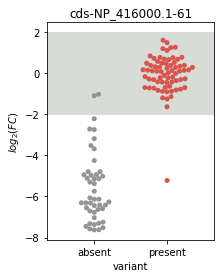

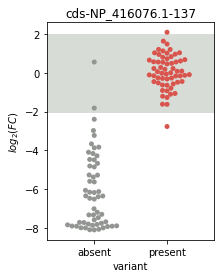

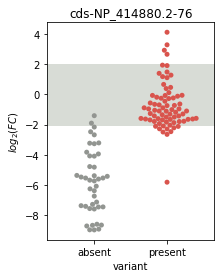

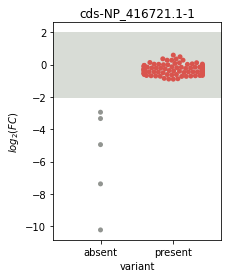

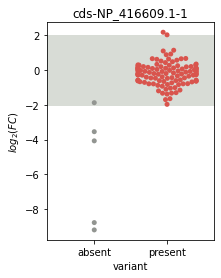

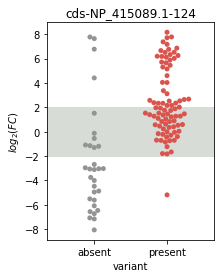

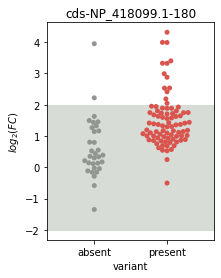

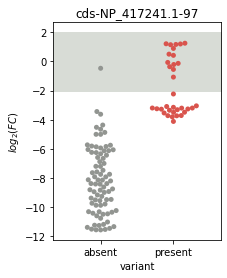

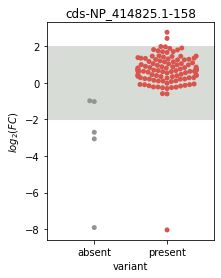

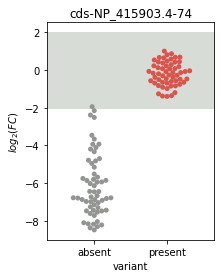

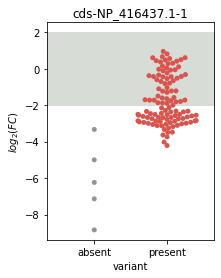

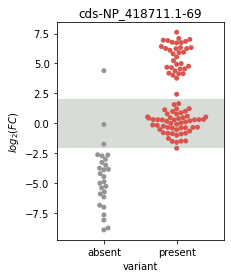

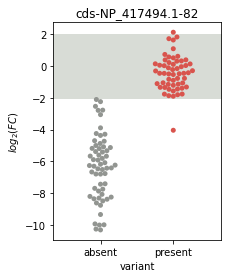

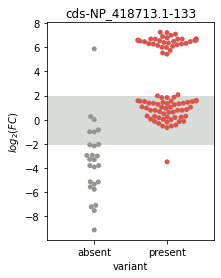

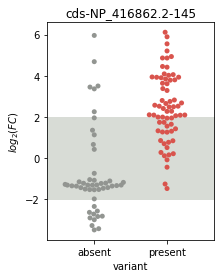

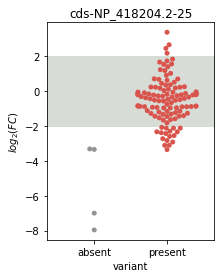

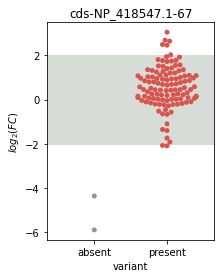

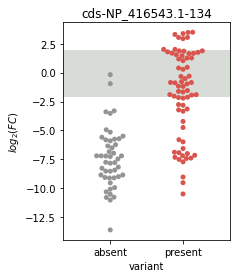

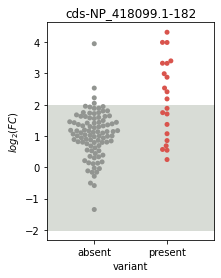

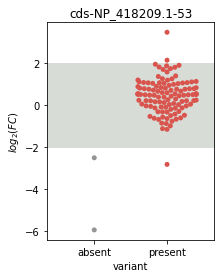

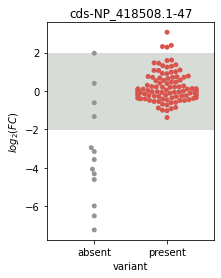

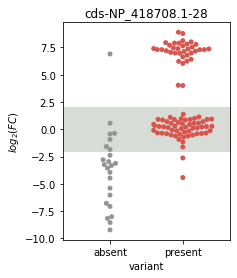

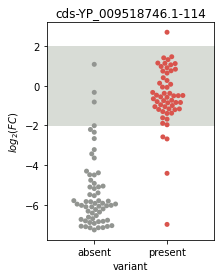

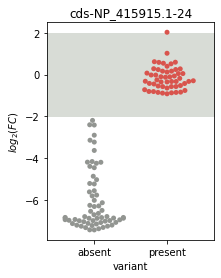

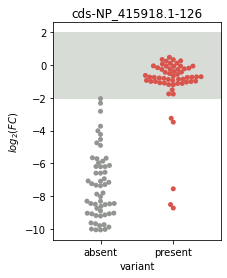

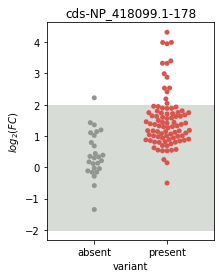

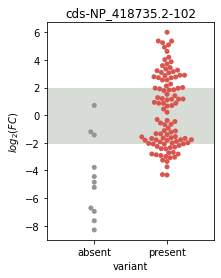

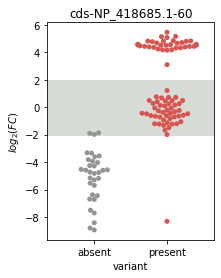

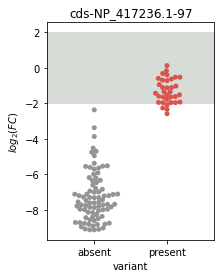

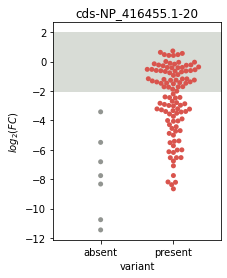

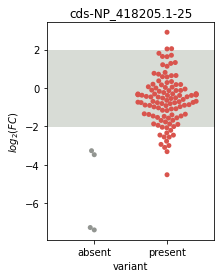

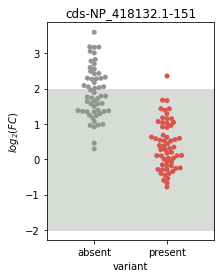

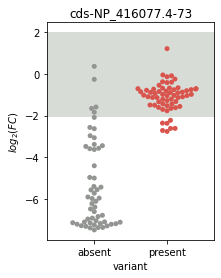

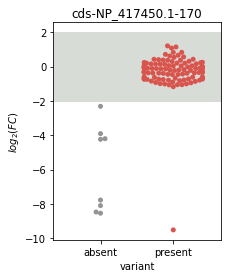

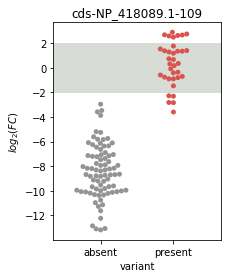

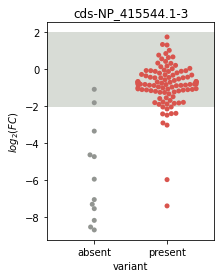

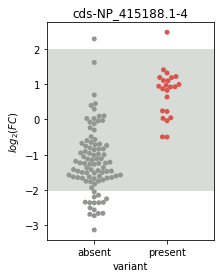

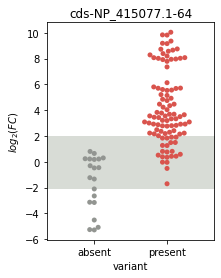

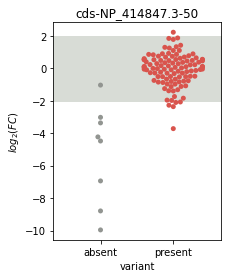

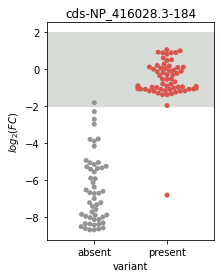

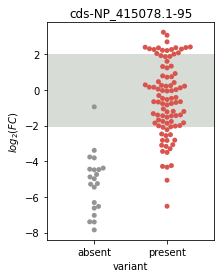

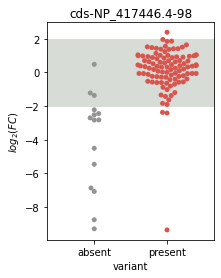

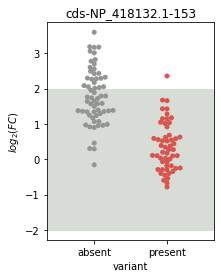

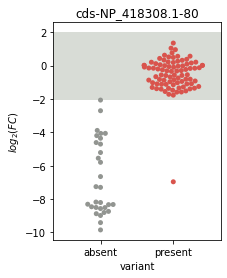

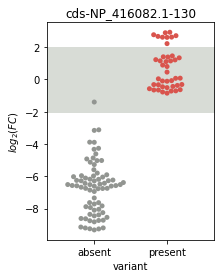

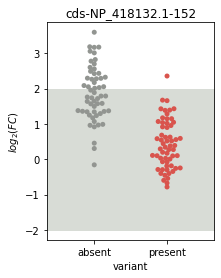

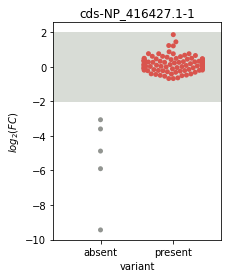

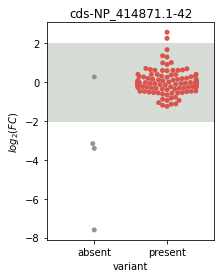

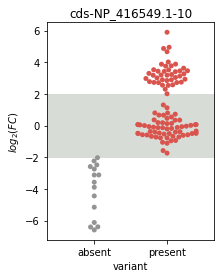

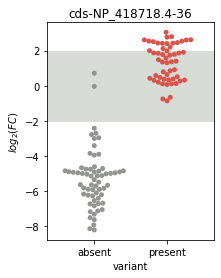

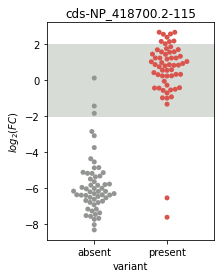

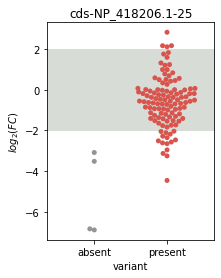

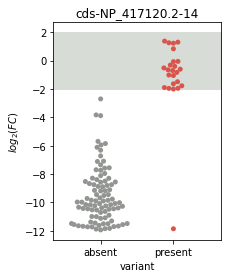

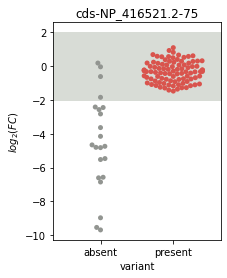

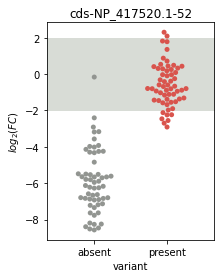

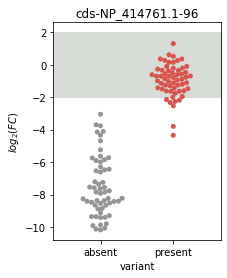

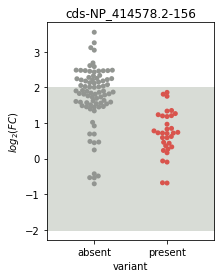

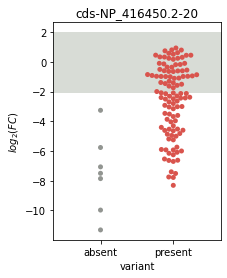

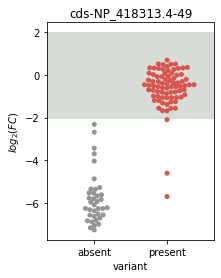

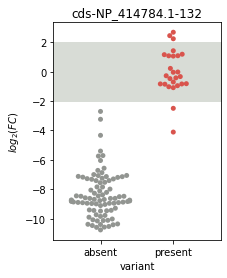

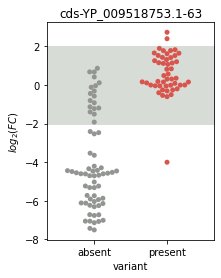

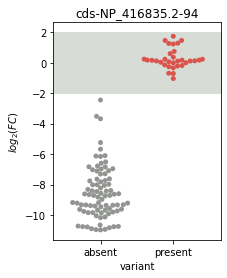

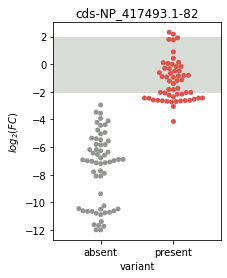

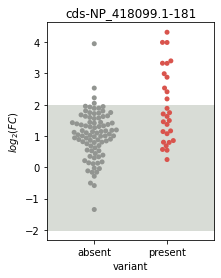

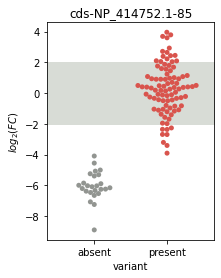

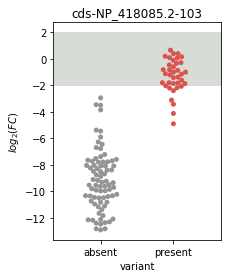

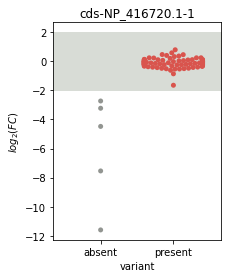

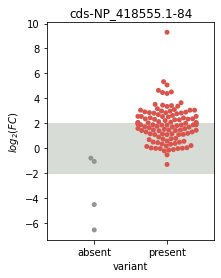

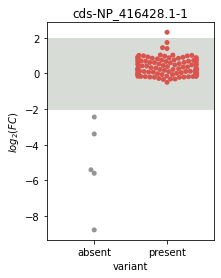

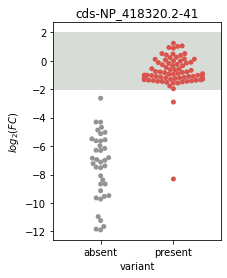

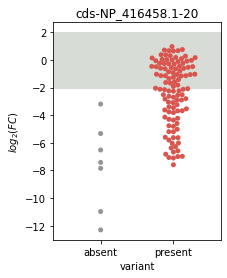

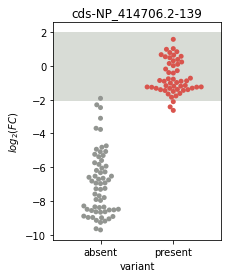

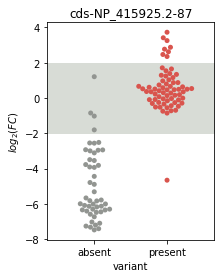

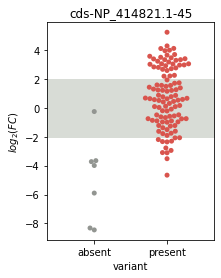

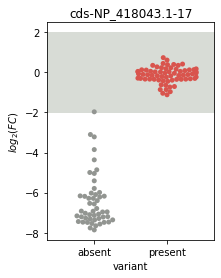

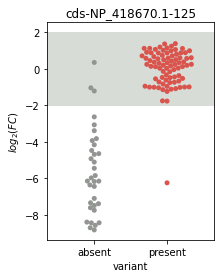

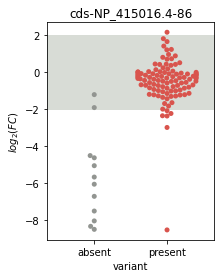

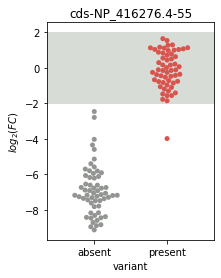

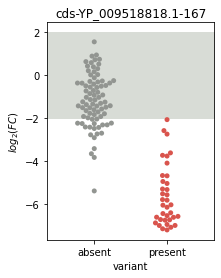

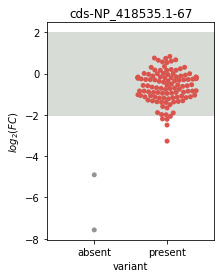

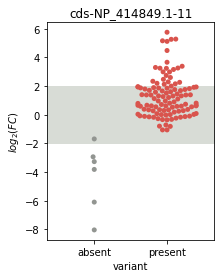

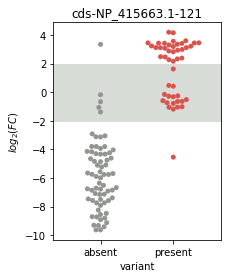

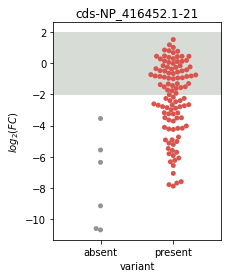

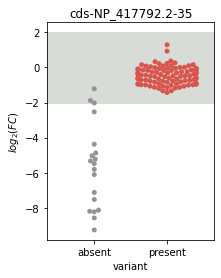

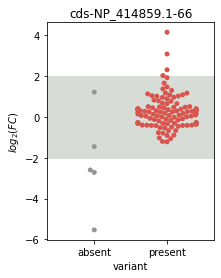

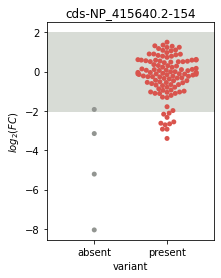

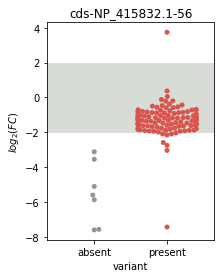

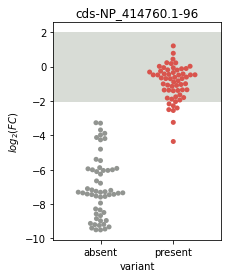

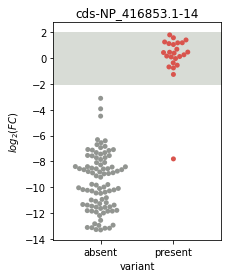

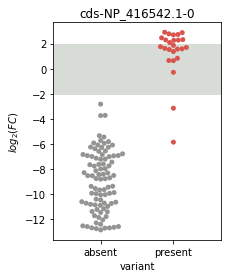

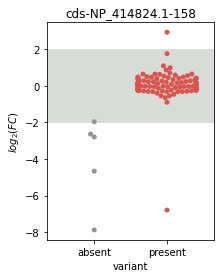

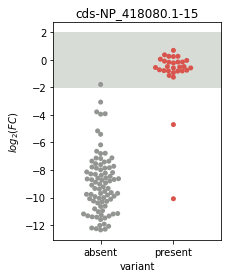

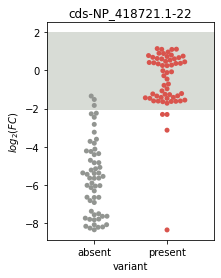

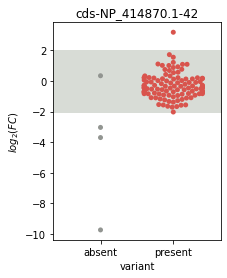

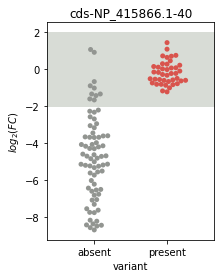

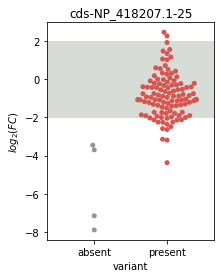

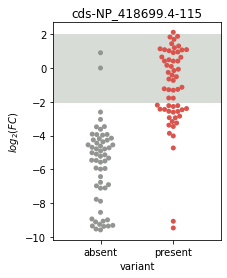

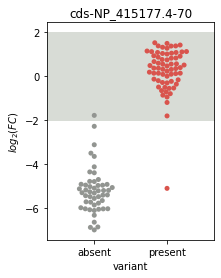

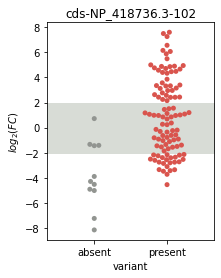

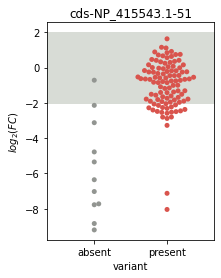

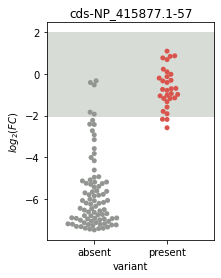

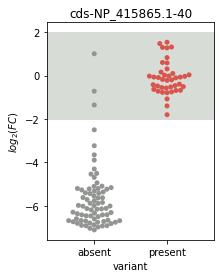

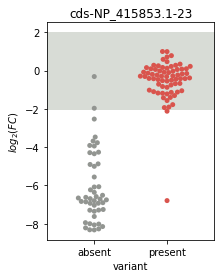

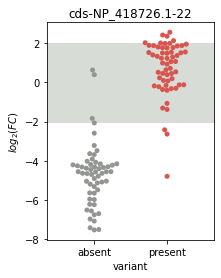

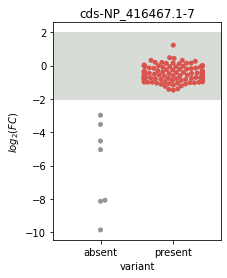

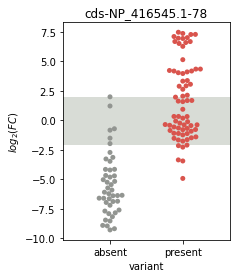

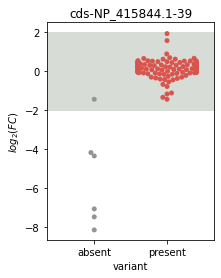

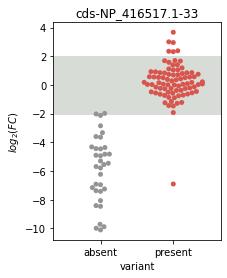

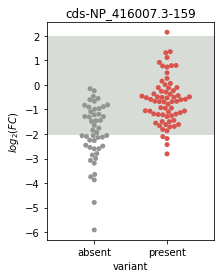

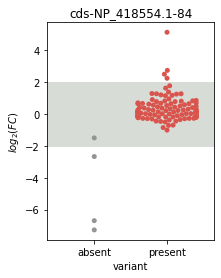

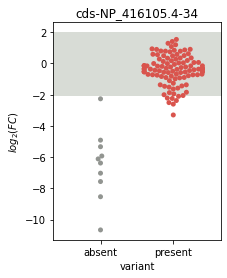

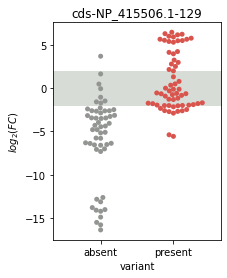

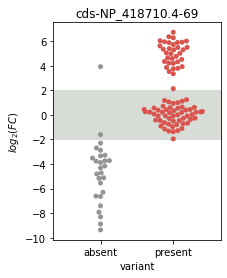

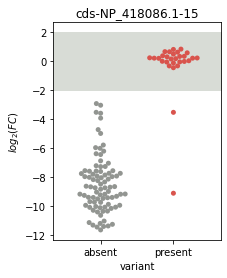

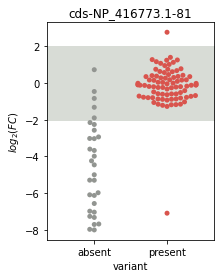

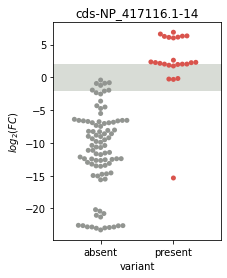

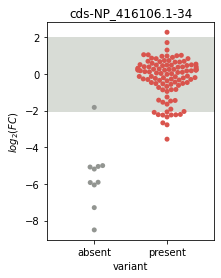

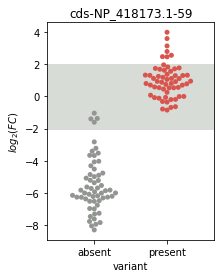

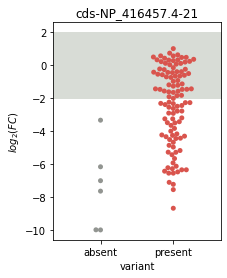

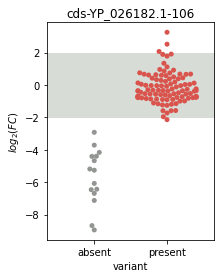

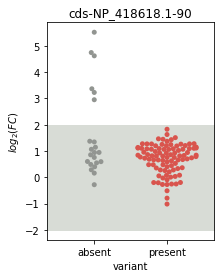

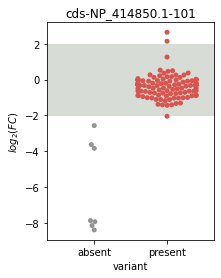

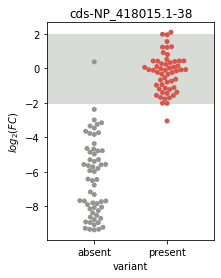

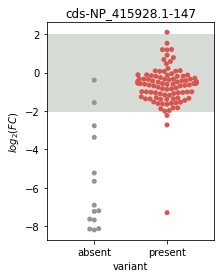

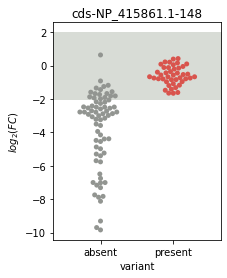

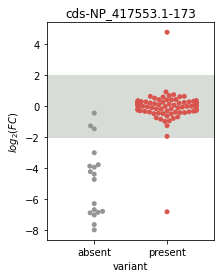

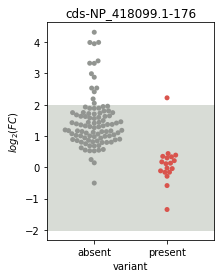

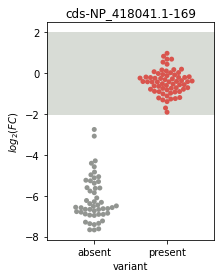

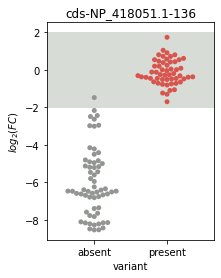

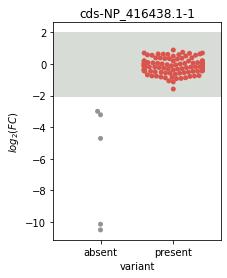

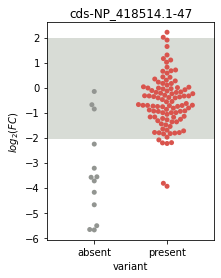

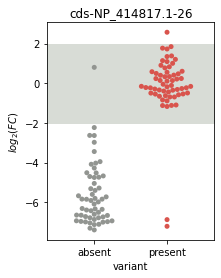

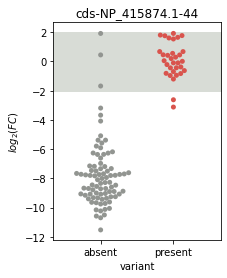

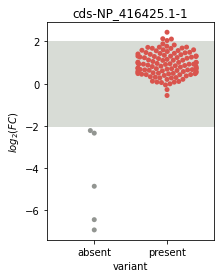

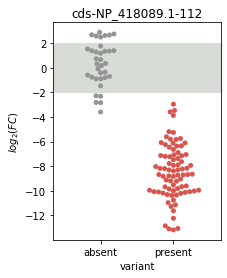

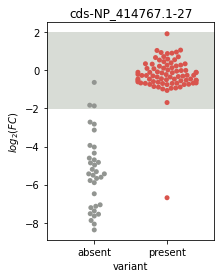

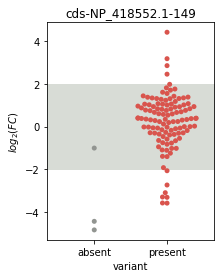

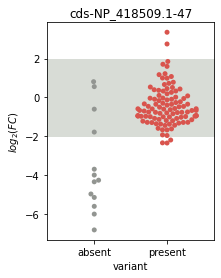

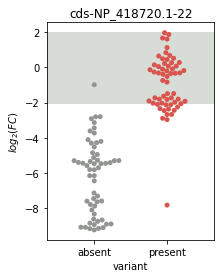

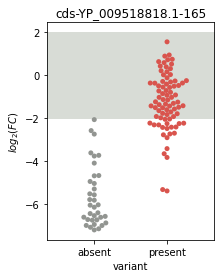

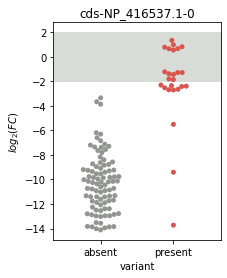

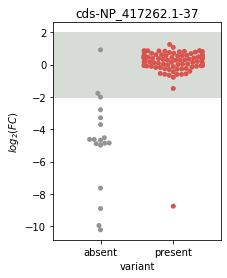

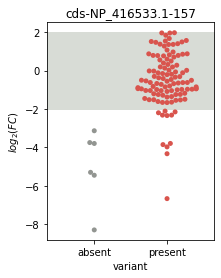

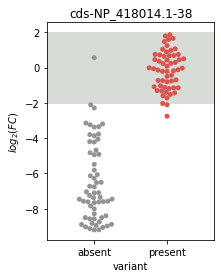

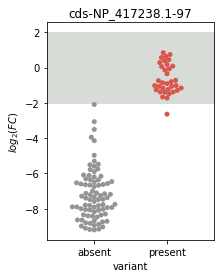

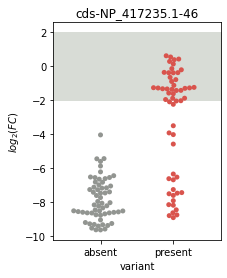

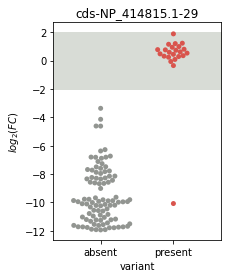

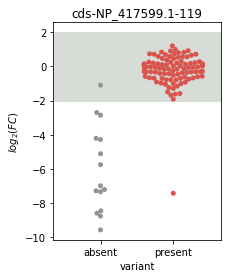

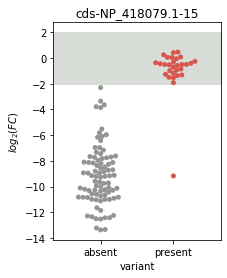

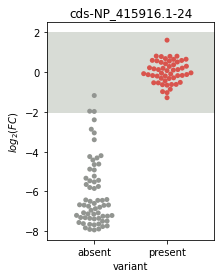

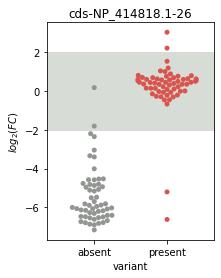

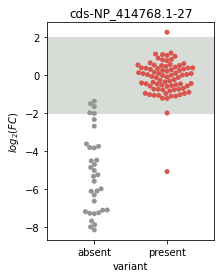

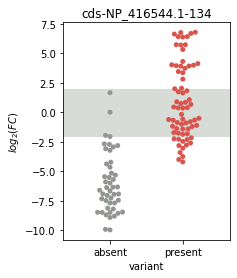

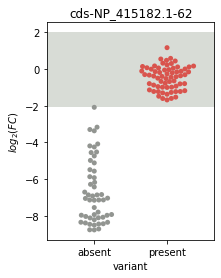

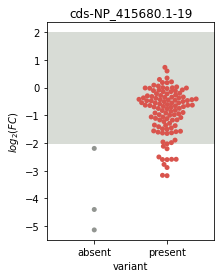

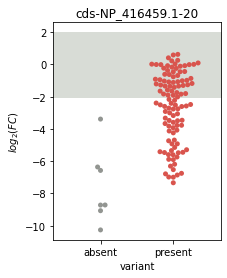

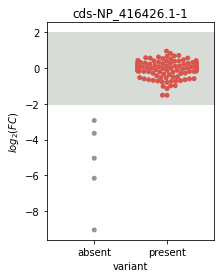

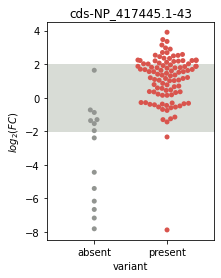

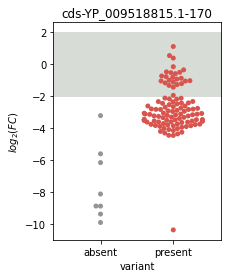

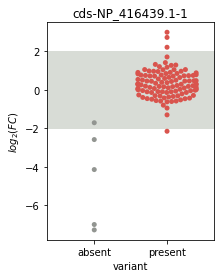

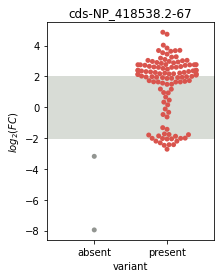

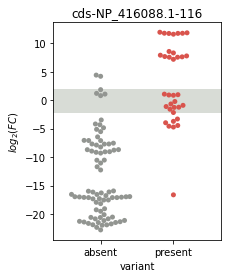

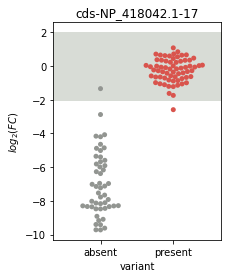

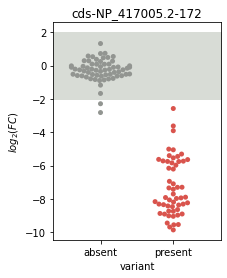

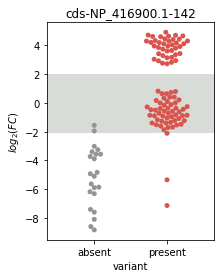

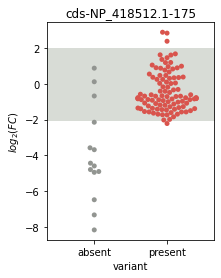

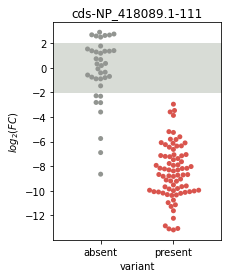

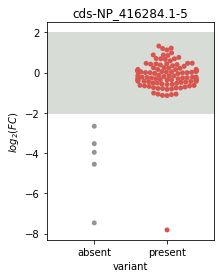

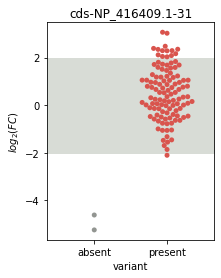

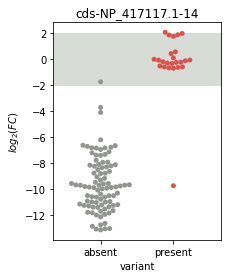

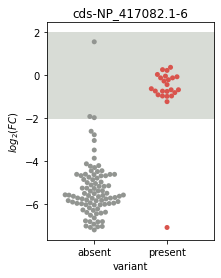

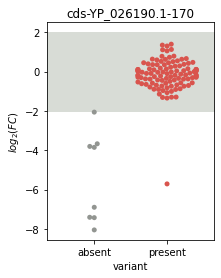

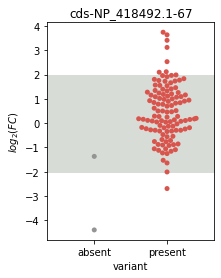

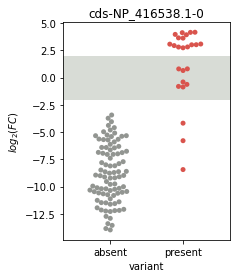

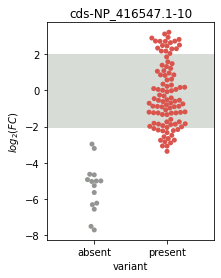

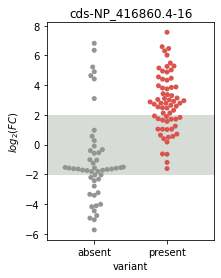

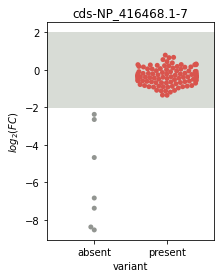

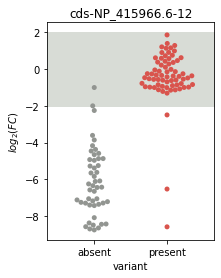

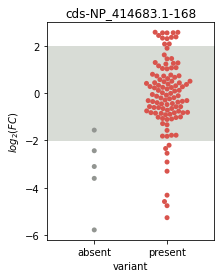

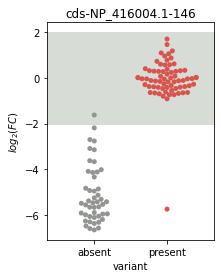

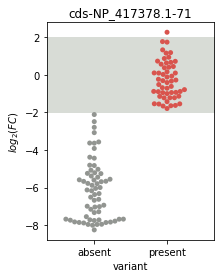

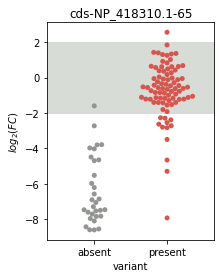

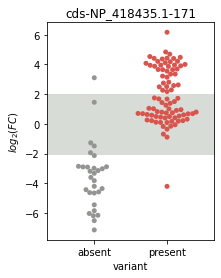

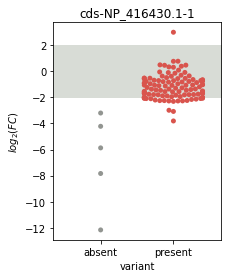

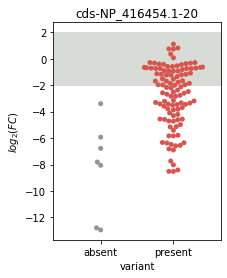

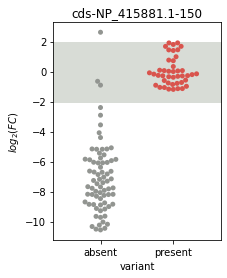

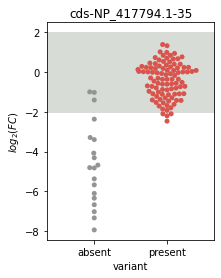

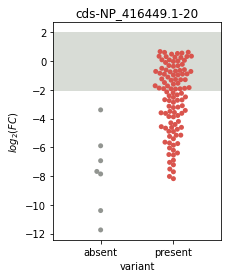

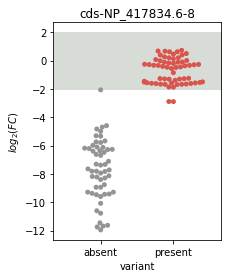

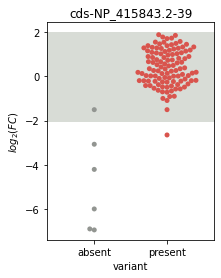

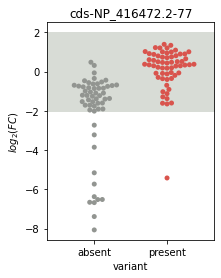

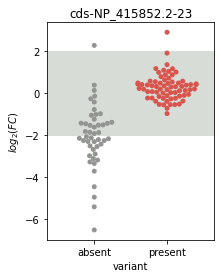

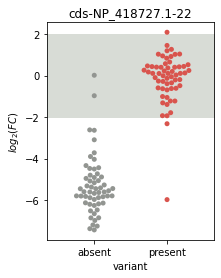

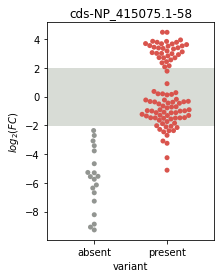

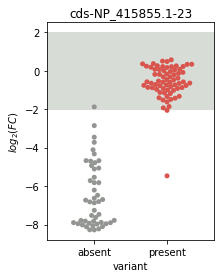

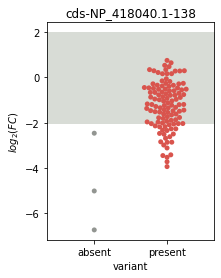

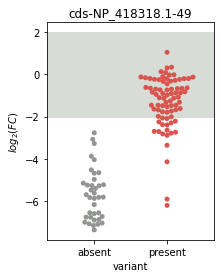

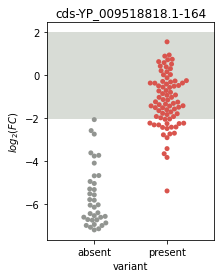

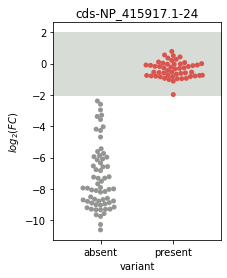

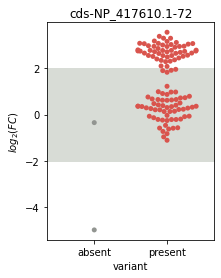

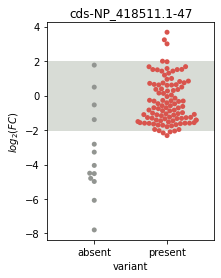

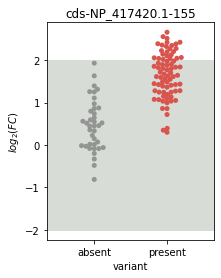

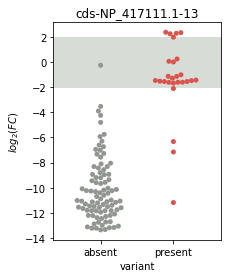

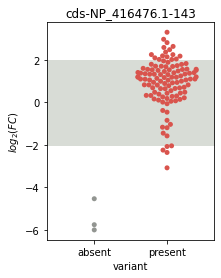

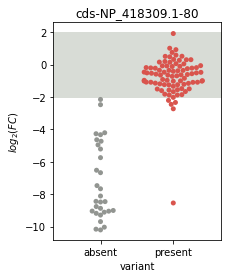

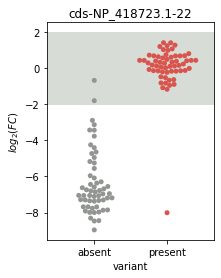

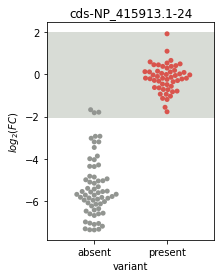

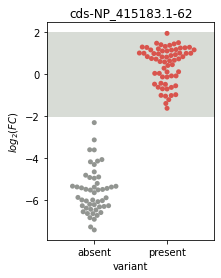

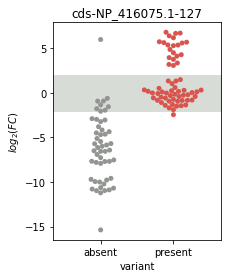

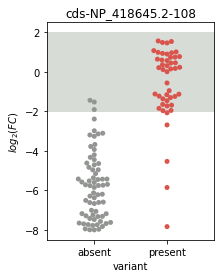

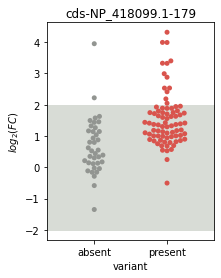

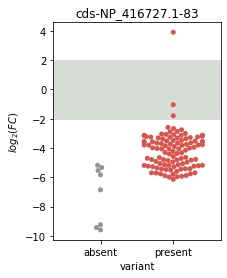

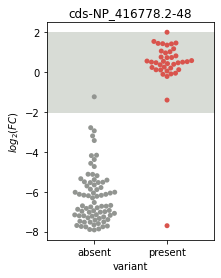

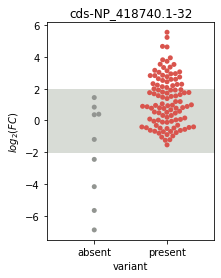

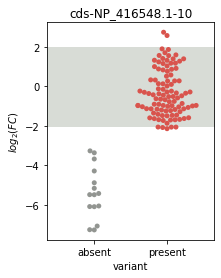

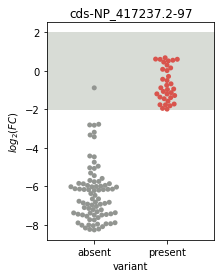

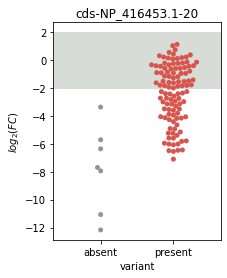

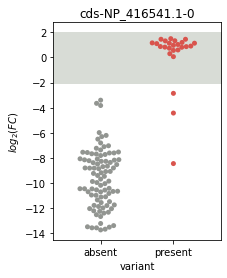

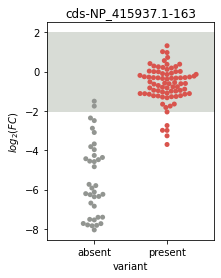

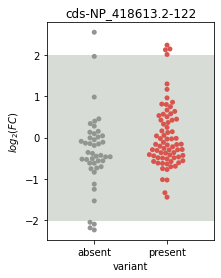

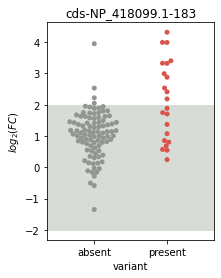

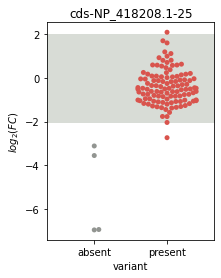

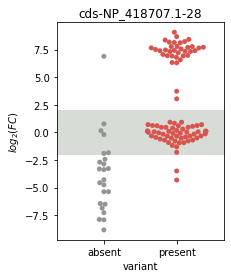

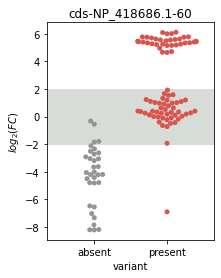

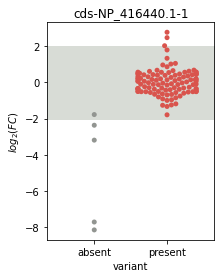

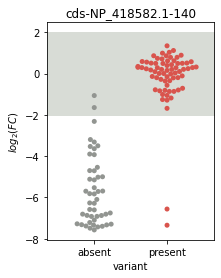

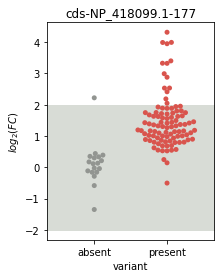

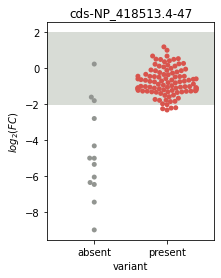

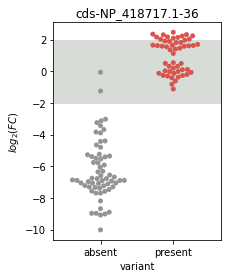

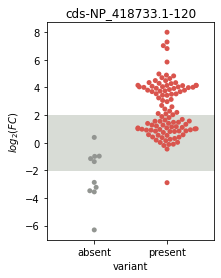

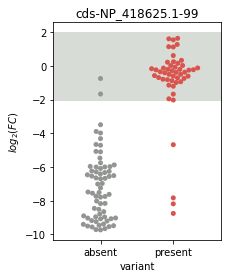

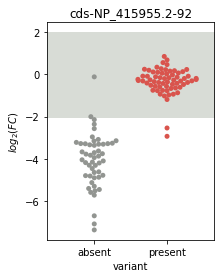

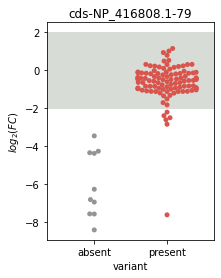

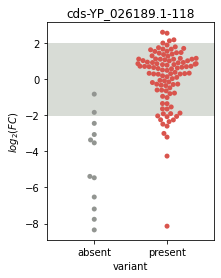

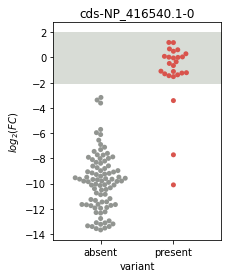

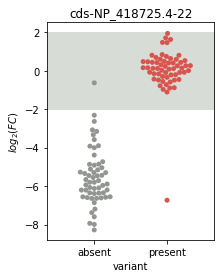

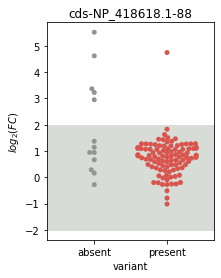

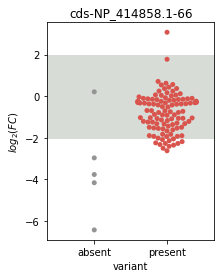

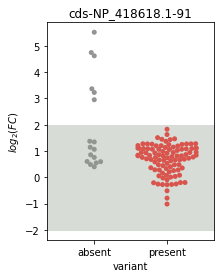

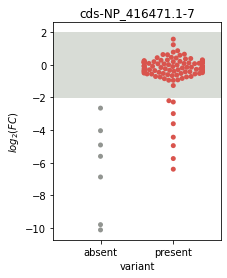

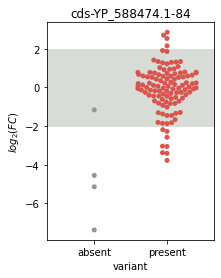

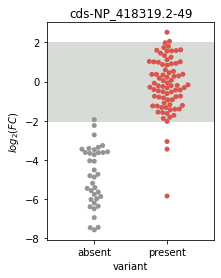

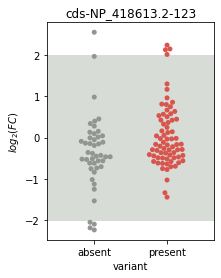

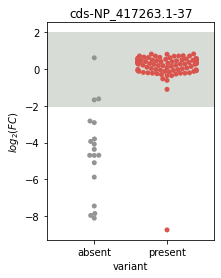

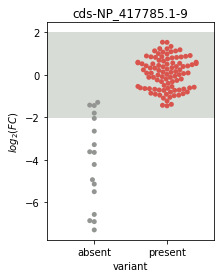

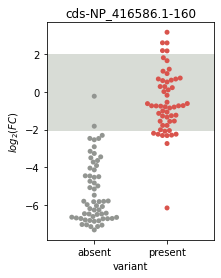

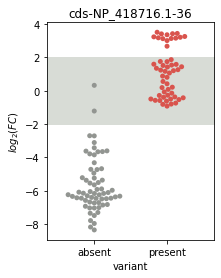

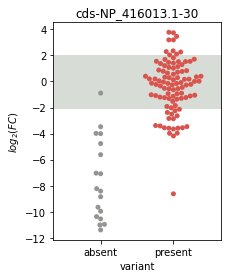

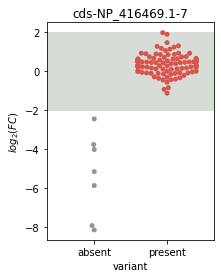

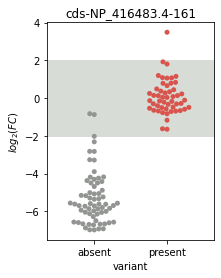

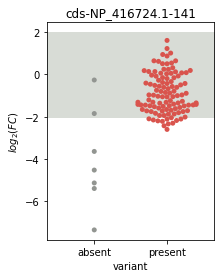

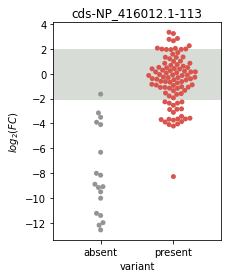

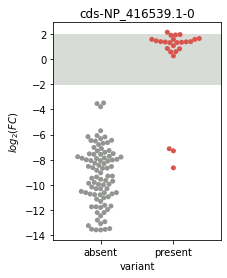

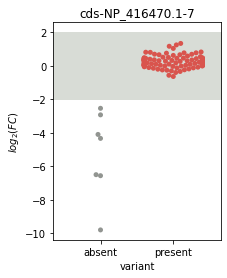

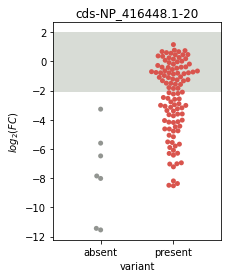

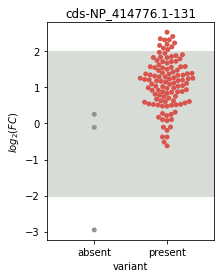

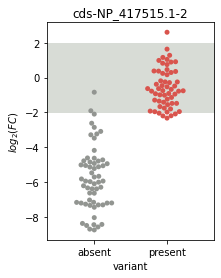

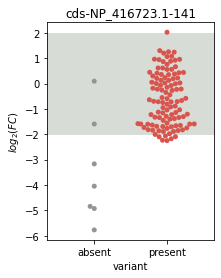

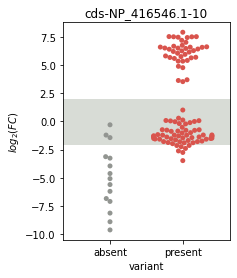

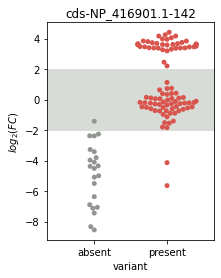

In [2]:
path = ('associations/asso_variant/')
associations = os.listdir(path)

try:
    os.mkdir('associations/swarmplots')
except Exception as e:
    print(e)
    pass

phenotypes = pd.read_csv('/fast-storage/bamu/ecoli/GWAS/2023_10_GWAS/phenotypes_new2.tsv', sep = '\t').rename(columns = {'Unnamed: 0': 'strain'}).set_index('strain')

for gene in associations:
    if gene.endswith('.tsv'):
        #extract gene name from file
        name =  '-'.join(gene.split('-')[:-1])
    
        #split k-sample column for each gwas output and convert its values into rows
        df = pd.read_csv(path + gene, sep = '\t', names = ['variant', 'lrt-pvalue', 'beta', 'k-samples'])
        df.rename(columns = {0: 'variant', 1:'lrt-pvalue', 2:'beta', 3:'k-samples'})
        
        df['k-samples'] = df['k-samples'].str.split('[,]') #split column values and convert to rows
        df = df.explode('k-samples').reset_index(drop = True)
        cols = list(df.columns)
        cols.append(cols.pop(cols.index('variant')))
        df = df[cols]
        
        #save split rows (which is each variant type) to a variable
        df1 = df.set_index('variant')
        
        #combine deseqoutput with gwas output
        df2 = phenotypes[name]
        df2 = df2.reset_index()
        strains = df1['k-samples'].to_list()
        
        outcome = []
        for row in df2.strain:
            if row in strains:
                outcome.append('present')
            else:
                outcome.append('absent')
                
        df2['outcomes'] = outcome
        plt.figure(figsize = (3,4))
        title = gene.split('.tsv')[0]
        
        ax = sns.swarmplot(data = df2, 
                           y= df2[df2.columns[1]], 
                           x="outcomes",
                           hue = 'outcomes',
                           hue_order = ['absent', 'present'],
                           palette = ['xkcd:grey', 'xkcd:pale red'], 
                           order=['absent', 'present'])
        
        ax.legend_.remove()
        
        ax.set_title(title)

        plt.ylabel("$log_{2}(FC)$")
        plt.xlabel("variant")
        
        plt.fill_between([-.75, 1.75],
                     [2, 2],
                     [-2, -2],
                     color='xkcd:light grey')
        
        plt.xlim(-0.65, 1.65)

        # add an horizontal line for ease of visualization
        plt.axhline(0, color='grey', ls='dashed', zorder=0)

        plt.savefig('associations/swarmplots/' + title + '.svg',
                    format = 'svg',
                    dpi = 300,
                    bbox_inches = 'tight',
                    transparent = True)
        